# Analyzing simple experiments

This notebook shows you how to analyze simple experiments. We expect basic knowledge from CCS1 and CCS2 - have a look at the course materials if you are unsure.

In [2]:
# only need to install this once, it's for some SPSSy stuff used in Psychology but not often used in Python
!pip install psython
!pip install pingouin
!pip install prettytable

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import numpy as np
import psython as psy
import pingouin as pg

## Loading the dataset

We first load the dataset and inspect it.
We also do necessary recoding.
Note that this is a "fake" dataset with data I simulated; also note that your dataset may look slightly different. You should know everything about loading, recoding etc. from CCS1 and CCS2.

In [3]:
df = pd.read_csv("data.csv")
df

,dv,group,gender,age,x1,x2,x3,x4,x5
0,3.125799,1,male,26,2.096090,1.867097,2.648194,0.116307,2.935158
1,2.366678,1,female,24,1.635612,1.340803,2.005062,0.088061,2.222336
2,3.013840,1,male,18,2.028176,1.789477,2.553342,0.112141,2.830028
3,1.856299,1,male,27,1.326019,0.986961,1.572667,0.069070,1.743085
4,3.788798,1,female,22,2.498261,2.326750,3.209890,0.140976,3.557722
...,...,...,...,...,...,...,...,...,...
360,3.194810,4,female,25,2.137951,1.914942,2.706660,0.118875,2.999960
361,4.590034,4,male,18,2.984286,2.882242,3.888702,0.170789,4.310091
362,4.089445,4,male,20,2.680631,2.535187,3.464600,0.152163,3.840033
363,3.443459,4,female,20,2.288780,2.087328,2.917317,0.128127,3.233444


### Let's look at what we have:

In [4]:
df['dv'].describe()

count    365.000000
mean       3.383098
std        0.755077
min        1.428526
25%        2.865476
50%        3.390215
75%        3.897036
max        5.802799
Name: dv, dtype: float64

In [5]:
df['group'].value_counts(sort=False)

1     98
2     77
3    102
4     88
Name: group, dtype: int64

In [6]:
df['gender'].value_counts(sort=False)

male      193
female    172
Name: gender, dtype: int64

In [7]:
df['age'].describe()

count    365.000000
mean      22.736986
std        2.902609
min       18.000000
25%       20.000000
50%       23.000000
75%       25.000000
max       27.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='count'>

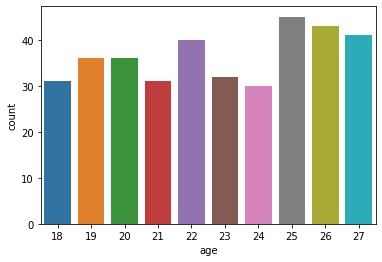

In [8]:
#or some plotting if we like
sns.countplot(x='age', data=df)

<AxesSubplot:xlabel='dv', ylabel='Count'>

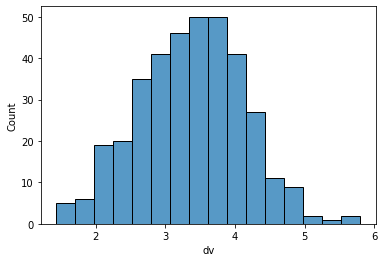

In [9]:
sns.histplot(x='dv', data=df)

## Some simple group comparison

<AxesSubplot:xlabel='group', ylabel='dv'>

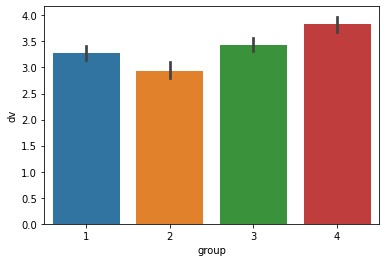

In [10]:
sns.barplot(y='dv', x='group', data=df)

<AxesSubplot:xlabel='group', ylabel='dv'>

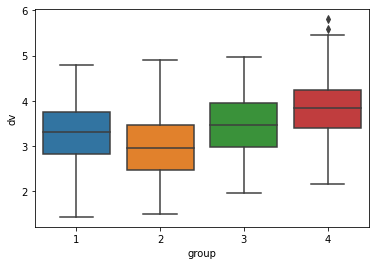

In [11]:
# maybe a boxplot is nicer?

sns.boxplot(y='dv', x='group', data=df)

In [12]:
# how does the dv differ?
df.groupby('group')['dv'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,98.0,3.272706,0.691306,1.428526,2.821665,3.305498,3.760571,4.796552
2,77.0,2.941768,0.695712,1.493880,2.463041,2.946119,3.470892,4.906704
3,102.0,3.439727,0.675162,1.948577,2.983307,3.470620,3.943603,4.973289
4,88.0,3.826560,0.715388,2.153351,3.396277,3.830987,4.245062,5.802799


In [13]:
# This is how one could compare the groups using a regresion analysis. Uncomment the following line if you want to see.

ols("dv~C(group) + age + C(gender)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dv   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     14.36
Date:                Thu, 02 Jun 2022   Prob (F-statistic):           7.91e-13
Time:                        23:30:21   Log-Likelihood:                -381.59
No. Observations:                 365   AIC:                             775.2
Df Residuals:                     359   BIC:                             798.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3063      0.297     11.119      0.000       2.722       3.891
C(group)[T.2]        -0.3379      0.106     -3.192      0.002      -0.546      -0.130
C(group)[T.3]         0.1757      0.099      1.783      0.075      -0.018       0.370
C(group)[T.4]         0.5491      0.102      5.380      0.000       0.348       0.750
C(gender)[T.male]    -0.0926      0.073     -1.260      0.208      -0.237       0.052
age                   0.0007      0.013      0.054      0.957      -0.024       0.025
==============================================================================
Omnibus:                        0.135   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.254
Skew:                           0.001   Prob(JB):                        0.881
Kurtosis:                       2.871   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# All analyses from the slides

In this section of the notebook, we show *all* analyses from the lecture slides and how to do them in Python, in the order in which they are mentioned on the slides.

Check for more simple analyses https://pingouin-stats.org/ (including mediation analysis!)

For everything related to regression (and more advanced stuff), you may want to have a look at https://www.statsmodels.org/.


## Check reliability (Cronbach's Alpha)

Let's check whether the variables called `x1, x2, x3, x4, x5` measure the same construct: 

In [14]:
alpha, report = psy.cronbach_alpha_scale_if_deleted(df[['x1','x2','x3','x4','x5']])

print(f"Cronbach's alpha={alpha[0]:.3f}, confidence interval= {alpha[1]}")
report

Cronbach's alpha=0.936, confidence interval= [0.925 0.946]


,Item,Scale Mean if Item Deleted,Scale Variance if Item Deleted,Corrected Item-Total Correlation,Cronbach's Alpha if Item Deleted
0,x1,8.214305,3.611207,1.0,0.895152
1,x2,8.420990,3.366683,1.0,0.888774
2,x3,7.600292,2.953713,1.0,0.887641
3,x4,10.340590,5.430052,1.0,0.990606
4,x5,7.289706,2.720246,1.0,0.895215


## t-test

You only need to specify the variable you group by (gender) and the variable you want to test (dv) in the first line of the code and we'll print a nicely formated sentence! (plus the table)

In [15]:
(label1, values1), (label2, values2) = df.groupby('gender')['dv']

testresult = pg.ttest(values1, values2)

print(f"We compare {label1} (M={np.mean(values1):.2f}, SD={np.std(values1):.3f}) "
     f"with {label2} (M={np.mean(values2):.2f}, SD={np.std(values2):.3f}), "
     f"t({testresult.iloc[0,1]})={testresult.iloc[0,0]:.3f}, "
     f"p={testresult.iloc[0,3]:.4f}.")

testresult

We compare female (M=3.43, SD=0.791) with male (M=3.35, SD=0.718), t(347.346215441861)=0.995, p=0.3203.


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.995357,347.346215,two-sided,0.320255,"[-0.08, 0.24]",0.10496,0.187,0.169661


## ANOVA


In [16]:
aov = pg.anova(data=df, dv='dv', between='group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,33.824756,3,11.274919,23.431682,7.029862e-14,0.162986
1,Within,173.706936,361,0.481183,NaN,NaN,NaN


In [17]:
# post-hoc test
df.pairwise_tukey(dv='dv', between='group').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,3.273,2.942,0.331,0.106,3.133,0.010,0.475
1,1,3,3.273,3.440,-0.167,0.098,-1.702,0.324,-0.240
2,1,4,3.273,3.827,-0.554,0.102,-5.437,0.000,-0.795
3,2,3,2.942,3.440,-0.498,0.105,-4.755,0.000,-0.715
4,2,4,2.942,3.827,-0.885,0.108,-8.174,0.000,-1.270
5,3,4,3.440,3.827,-0.387,0.101,-3.833,0.001,-0.555


## ANOVA with interaction effect

Let's say we don't have a `1x4` but a `2x2` design:

In [29]:
# imagine that group 1 is personalized and interactive, 2 is only personalized, 3 is not interactive but personalized, and 4 is neither
df['personalized']=False
df['interactive']=False
df.loc[df['group']==1,'personalized']=True
df.loc[df['group']==2,'personalized']=True
df.loc[df['group']==1,'interactive']=True
df.loc[df['group']==3,'interactive']=True

In [32]:
df.anova(dv="dv", between=["interactive", "personalized"],effsize="n2").round(3)

,Source,SS,DF,MS,F,p-unc,n2
0,interactive,0.177,1.0,0.177,0.369,0.544,0.001
1,personalized,21.929,1.0,21.929,45.574,0.000,0.106
2,interactive * personalized,11.614,1.0,11.614,24.137,0.000,0.056
3,Residual,173.707,361.0,0.481,NaN,NaN,NaN


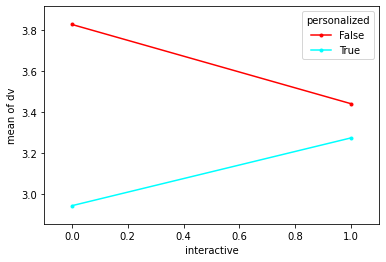

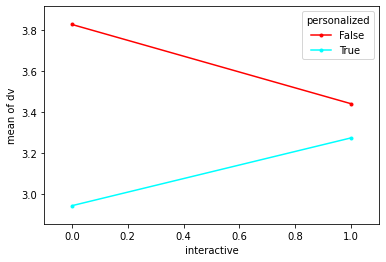

In [41]:
# I don't think one should do this when the x-axis is continous, but ANOVA-people sometimes do this:

from statsmodels.graphics.factorplots import interaction_plot
interaction_plot(df['interactive'], df['personalized'], df['dv'])

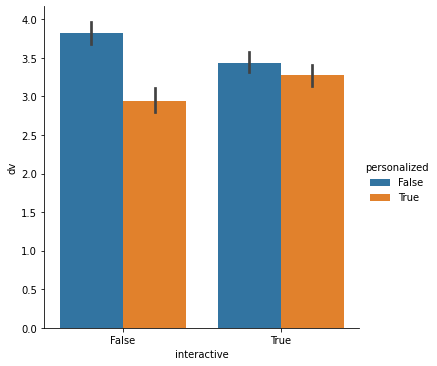

In [43]:
# better plot:
sns.catplot(x='interactive', y='dv', hue='personalized', kind='bar', data=df)

## ANCOVA

In [36]:
df['gender_int'] = df['gender'].map({"male":1,"female":0})

In [38]:
pg.ancova(data=df, dv='dv', covar=['age', 'gender_int'], between='group',effsize="n2")

,Source,SS,DF,F,p-unc,n2
0,group,34.018652,3,23.539438,6.243035e-14,0.163768
1,age,0.001413,1,0.002933,9.568421e-01,0.000007
2,gender_int,0.764853,1,1.587736,2.084684e-01,0.003682
3,Residual,172.939507,359,NaN,NaN,NaN
